Лабораторная работа №8 “Выявление аномалий”
=====
Лабораточная работа выполнена на языке **Python** c помощью интерактивной оболочки **Jupyter Notebook**.
Исходный код работы - lab8.py.
Файл jupyter notebook - lab8.ipynb.

Набор данных ex8data1.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X1 и X2 - задержка в мс и пропускная способность в мб/c серверов. Среди серверов необходимо выделить те, характеристики которых аномальные. Набор разделен на обучающую выборку (X), которая не содержит меток классов, а также валидационную (Xval, yval), на которой необходимо оценить качество алгоритма выявления аномалий. В метках классов 0 обозначает отсутствие аномалии, а 1, соответственно, ее наличие.
Набор данных ex8data2.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 11-мерную переменную X - координаты точек, среди которых необходимо выделить аномальные. Набор разделен на обучающую выборку (X), которая не содержит меток классов, а также валидационную (Xval, yval), на которой необходимо оценить качество алгоритма выявления аномалий.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

#### Загружаем данные ex8data1.mat из файла.

In [3]:
data1 = scipy.io.loadmat('ex8data1.mat')
X = data1['X']
X_val = data1['Xval']
y_val = np.squeeze(data1['yval'])

#### График загруженных данных в виде диаграммы рассеяния.

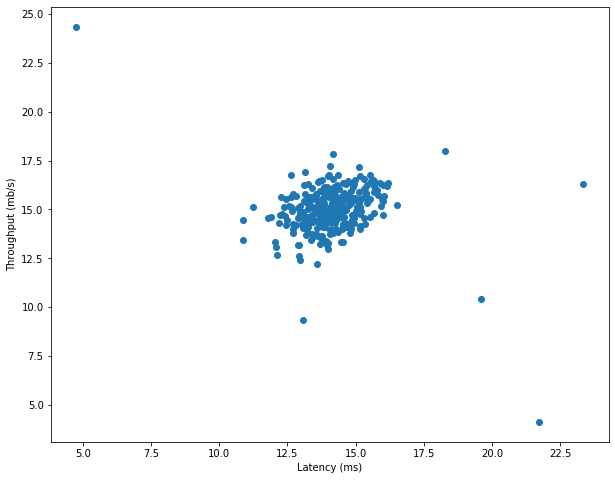

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

#### Найдем параметры распределений случайных величин.

In [5]:
def gaussian_params(X):
    m = X.shape[0]
    mu = (1 / m) * np.sum(X, axis=0)
    sigma2 = (1 / m) * np.sum((X - mu) ** 2, axis=0)
    return mu, sigma2

In [6]:
mu, sigma2 = gaussian_params(X)
print(f'Mu = {mu}, sigma^2 = {sigma2}')

Mu = [14.11222578 14.99771051], sigma^2 = [1.83263141 1.70974533]


#### Представим данные в виде двух независимых нормально распределенных случайных величин.

In [7]:
def gaussian_distribution(X, mu, sigma2):
    xmu2 = (X-mu.T) ** 2
    xmu2sg = xmu2 / sigma2.T
    exp = np.exp(-0.5 * xmu2sg)
    dn = np.sqrt(2 * np.pi * sigma2.T)
    p = exp / dn
    p = np.product(p, axis=1)
    return p

#### График плотности распределения получившейся случайной величины в виде изолиний, совместив его с графиком из пункта 2.

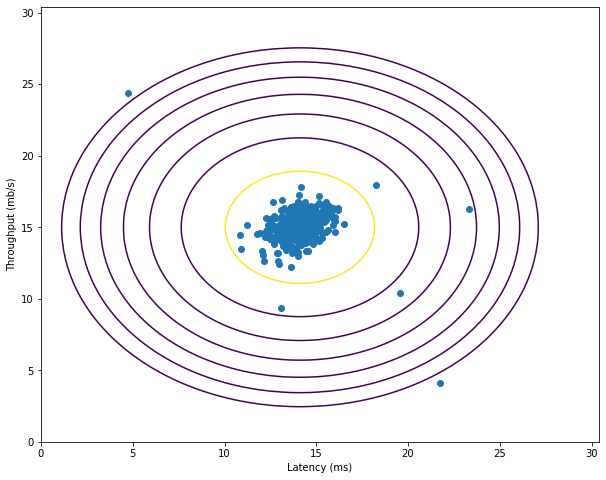

In [11]:
mu, sigma2 = gaussian_params(X)
X1, X2 = np.meshgrid(np.arange(0, 30.5, 0.1), np.arange(0, 30.5, 0.1))
Z = gaussian_distribution(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
Z = Z.reshape(X1.shape)
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.contour(X1, X2, Z, 10.**np.arange(-21, -2, 3))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

#### Подберем значение порога для обнаружения аномалий на основе валидационной выборки. В качестве метрики используем F1-меру.

In [12]:
def select_threshold(yval, pval):
    best_eps = 0
    best_f1 = 0
    for eps in np.linspace(1.01 * np.min(pval), np.max(pval), 1000):
        predictions = (pval < eps)
        tp = np.sum((predictions == yval) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        f1 = 2 * prec * rec / (prec + rec)
        if f1 > best_f1:
            best_f1 = f1
            best_eps = eps

    return best_eps, best_f1

In [13]:
mu, sigma2 = gaussian_params(X)
p_val = gaussian_distribution(X_val, mu, sigma2)
eps, f1 = select_threshold(y_val, p_val)
print(f'Selected epsilon = {eps} with F1 = {f1}')

Selected epsilon = 8.999852631901397e-05 with F1 = 0.8750000000000001


#### Выделим аномальные наблюдения на графике из пункта 5 с учетом выбранного порогового значения.

In [15]:
p = gaussian_distribution(X, mu, sigma2)
outliers = p < eps

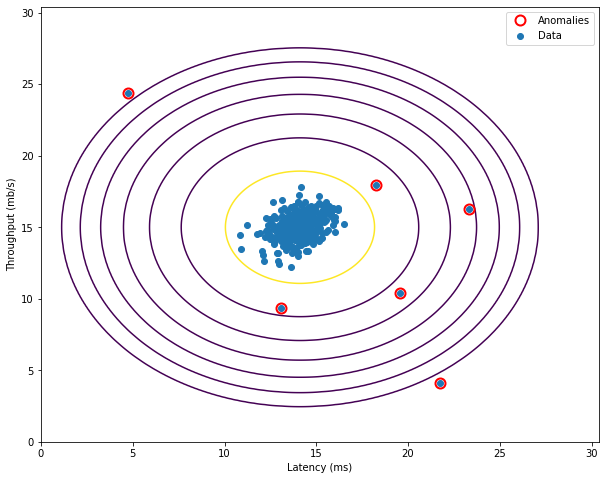

In [19]:
mu, sigma2 = gaussian_params(X)
X1, X2 = np.meshgrid(np.arange(0, 30.5, 0.1), np.arange(0, 30.5, 0.1))
Z = gaussian_distribution(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
Z = Z.reshape(X1.shape)
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.contour(X1, X2, Z, 10.**np.arange(-21, -2, 3))
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.legend(['Anomalies', 'Data'])
plt.show()

#### Загружаем данные ex8data2.mat из файла.

In [35]:
data2 = scipy.io.loadmat('ex8data2.mat')
X = data2['X']
X_val = data2['Xval']
y_val = np.squeeze(data2['yval'])

#### Параметры распределения случайной величины.

In [36]:
mu, sigma2 = gaussian_params(X)
print(f'Mu = {mu},\nsigma^2 = {sigma2}')

Mu = [  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252],
sigma^2 = [60.97489373 53.20572186 58.51546272 84.20403725 65.26859177 89.57487757
 55.63349911 87.16233783 29.62926829 70.7852052  50.50356719]


#### Представим данные в виде 11-мерной нормально распределенной случайной величины.

In [41]:
p = gaussian_distribution(X, mu, sigma2)

#### Подберем значение порога для обнаружения аномалий на основе валидационной выборки.

In [38]:
p_val = gaussian_distribution(X_val, mu, sigma2)
eps, f1 = select_threshold(y_val, p_val)
print(f'Selected epsilon = {eps} with F1 = {f1}')

Selected epsilon = 1.3786074987947628e-18 with F1 = 0.6153846153846154


#### Выделим аномальные наблюдения в обучающей выборке

In [40]:
anomalies = np.sum(p < eps)
print(f'Anomalies found: {anomalies}')

Anomalies found: 117


## Вывод
В данной работе была показана работа алгоритма выявления аномалий с помощью гаусовского нормального распределения, реализованы фунции расчета параметром распределения, нахождения гаусовского распределения, нахождения порога определения аномалий.